In [70]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV,train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression,ElasticNet
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer,make_column_selector
import warnings
warnings.filterwarnings('ignore')


In [3]:
HR = pd.read_csv('HR_comma_sep.csv')

In [5]:
HR.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.10,0.77,6,247,4,0,1,0,sales,low
3,0.92,0.85,5,259,5,0,1,0,sales,low
4,0.89,1.00,5,224,5,0,1,0,sales,low


In [10]:
X = HR.drop('left',axis=1)
y = HR['left']

In [12]:
ohe = OneHotEncoder(sparse_output=False,drop='first').set_output(transform='pandas')

In [17]:
ct = make_column_transformer(('passthrough',make_column_selector(dtype_exclude=object) ),
                            (ohe,make_column_selector(dtype_include=object) ),
                            verbose_feature_names_out=False).set_output(transform='pandas')

In [24]:
lr = LogisticRegression()

In [27]:
kfold = StratifiedKFold(n_splits=5,random_state=24,shuffle=True)

In [29]:
pipe = Pipeline([('CT',ct),('LR',lr)])

In [31]:
params = {'LR__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],'LR__multi_class':['ovr','multinomial'],'LR__C':np.linspace(0.001,10,20)}


In [48]:
gcv = GridSearchCV(pipe , param_grid=params,cv=kfold,verbose=3)

In [49]:

gcv.fit(X,y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.760 total time=   0.1s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.759 total time=   0.1s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.761 total time=   0.1s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.760 total time=   0.1s
[CV 5/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.755 total time=   0.1s
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 5/5] END LR__C=0.001, LR__multi_class=ovr, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000018C352E9BE0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transfor...
       2.10605263e+00, 2.63231579e+00, 3.15857895e+00, 3.68484211e+00,
       4.21110526e+00, 4.73736842e+00, 5.26363158e+00, 5.78989474e+00,
       6.31615789e+00, 6.84242105e+00, 7.36868421e+00, 7.89494737e+00,
       8.42121053e+00, 8.94747368e+00, 9.47373684e+00, 1.00000000e+01]),
                         'LR__multi_class': ['ovr', 'multinomial'],
                         'LR__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'newton-cholesky', 'sag', 'saga']},
             verbose=3)

In [50]:
gcv.best_params_

{'LR__C': 10.0, 'LR__multi_class': 'ovr', 'LR__solver': 'lbfgs'}

In [51]:
gcv.best_score_

0.8034011337112371

In [52]:
pd_cv = pd.DataFrame(gcv.cv_results_)
pd_cv.shape

(240, 16)

In [53]:
best_model = gcv.best_estimator_

In [54]:
tst = pd.read_csv('tst_hr.csv')

In [55]:
best_model.predict(tst)

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [56]:
tst['predictions'] = best_model.predict(tst)

In [57]:
tst['predictions']

0     1
1     0
2     1
3     1
4     0
5     0
6     1
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
Name: predictions, dtype: int64

#### ROC Curve

In [61]:
X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=24,test_size=0.3,stratify=y)

In [62]:
ohe = OneHotEncoder(sparse_output=False,drop='first').set_output(transform='pandas')

In [63]:
ct = make_column_transformer(('passthrough',make_column_selector(dtype_exclude=object) ),
                            (ohe,make_column_selector(dtype_include=object) ),
                            verbose_feature_names_out=False).set_output(transform='pandas')

In [64]:
lr = LogisticRegression()

In [65]:
pipe = Pipeline([('CT',ct),('LR',lr)])

In [66]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000018C38D442C0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000018C38CF38C0>)],
                                   verbose_feature_names_out=False)),
                ('LR', LogisticRegression())])

In [67]:
y_pred_prob = pipe.predict_proba(X_test)

In [68]:
p_y_1 = y_pred_prob[:,1]

In [69]:
m1spec , sens , thresholds = roc_curve(y_test,p_y_1)

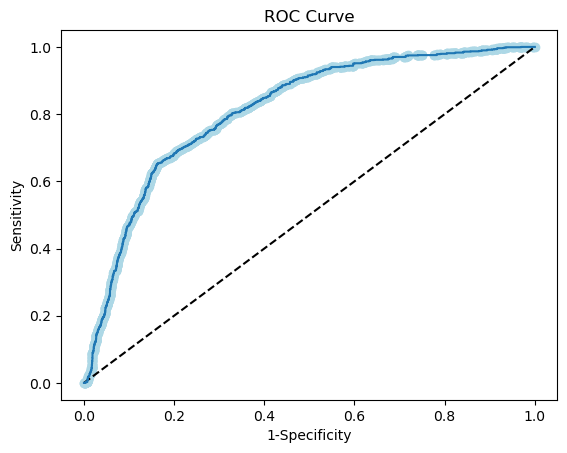

0.8108072160761836

In [83]:
plt.plot([0,1],[0,1],'k--')
plt.plot(m1spec,sens)
plt.scatter(m1spec,sens,c='lightblue')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.show()
roc_auc_score(y_test,p_y_1)